# Amazon Bedrock and Stability.ai Stable Diffusion XL 1.0 Video Animation Demo

In this 3-part demonstration we will learn how to use the AWS SDK for Python (Boto3) to create Generative AI images and simple video animations using [Amazon Bedrock](https://aws.amazon.com/bedrock/) and [Stability.ai](https://stability.ai/stable-image) Stable Diffusion XL 1.0 model.

1. Text-to-image
2. Image-to-image
3. Video-to-video (video-frame-frame-video)

Technologies:

- **Amazon Bedrock**: Amazon Bedrock is a fully managed service that offers a choice of high-performing foundation models (FMs) from leading AI companies like AI21 Labs, Anthropic, Cohere, Meta, Mistral AI, Stability AI, and Amazon via a single API

- **Stable Diffusion XL Model**: Stable Diffusion XL or SDXL is the latest image generation model that is tailored towards more photorealistic outputs with more detailed imagery and composition compared to previous SD models, including SD 2.1. Stable Diffusion XL is a significant advancement in image generation capabilities, offering enhanced image composition and face generation that results in stunning visuals and realistic aesthetics.

References:

- [Amazon Bedrock SDXL 1.0 Documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-image-image.html)
- [Stability.ai API Documentation](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/imageToImage)


## Prerequisites


### Python Environment

Create a virtual Python environment and install the required packages.


In [ ]:
# # Create virtual python environment
# !python -m pip install virtualenv -Uq
# !python -m virtualenv bedrock-venv

# # Activate the virtual environment
# !bedrock-venv\Scripts\pip install ipykernel
# !bedrock-venv\Scripts\python -m ipykernel install --user --name=bedrock-venv
# !bedrock-venv\Scripts\activate.bat

Lệnh trên chạy trên jupyter notebook không được, vui lòng mở terminal để chạy các lệnh sau:

`python -m pip install virtualenv -Uq`

`python -m virtualenv bedrock-venv`

`bedrock-venv\Scripts\activate.bat`

`pip install jupyterlab` - nếu chạy trên jupyterlab

`jupyter-lab`

### Select New Kernel

Change the kernel for this notebook to `bedrock-venv`.


In [1]:
# Install Python requirements
!python -m pip install -r requirements.txt -Uq

### Authenticate with Your AWS Credentials

Your method of authentication may vary depending on your environment.


In [2]:
# Authenticate with AWS using your credentials

import os
from dotenv import load_dotenv

# Tải biến môi trường từ file .env
load_dotenv()

# Sử dụng biến môi trường trong code
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
aws_session_token = os.getenv("AWS_SESSION_TOKEN")

### Install FFmpeg

Install [FFmpeg](https://ffmpeg.org/). Directions vary depending in your OS: Mac, Linux, or Windows.


In [ ]:
# %%sh

# # Install ffmpeg on mac using homebrew
# # https://phoenixnap.com/kb/ffmpeg-mac

# brew update
# # brew upgrade # this is optional (note: will upgrade all packages and could take awhile)
# brew install ffmpeg

Nếu đang chạy notebook này ở windows, đừng chạy lệnh trên, hãy đi đến đường dẫn [này](https://github.com/BtbN/FFmpeg-Builds/releases).

Sau đó tải về phiên bản cho windows

Giải nén, đặt biến môi trường (Environment Variable) trỏ đến đường dẫn ./bin trong thư mục đã giải nén

### Create Subdirectories for Content

We will use six different folders to hold our content: the source and generated images, frames, and videos. Four of the subdirectories exist in the project with samples. We will create the remaining two subdirectories. For the source and generated frames subdirectories, we will create additional subdirectories to hold each video's frames. Feel free to create additional subdirectories.


In [8]:
# Shell commands using corrected paths
!mkdir .\content\source_videos
!mkdir .\content\source_frames

!mkdir .\content\source_frames\demo1
!mkdir .\content\source_frames\demo2
!mkdir .\content\source_frames\demo3
!mkdir .\content\source_frames\demo4

!mkdir .\content\generated_images\

!mkdir .\content\generated_frames\demo1
!mkdir .\content\generated_frames\demo2
!mkdir .\content\generated_frames\demo3
!mkdir .\content\generated_frames\demo4

!mkdir .\content\generated_videos\

!dir .\content

A subdirectory or file .\content\source_videos already exists.
A subdirectory or file .\content\source_frames already exists.
A subdirectory or file .\content\source_frames\demo1 already exists.
A subdirectory or file .\content\source_frames\demo2 already exists.
A subdirectory or file .\content\source_frames\demo3 already exists.
A subdirectory or file .\content\source_frames\demo4 already exists.
A subdirectory or file .\content\generated_frames\demo1 already exists.
A subdirectory or file .\content\generated_frames\demo2 already exists.
A subdirectory or file .\content\generated_frames\demo3 already exists.
A subdirectory or file .\content\generated_frames\demo4 already exists.


 Volume in drive D is DATA
 Volume Serial Number is C62F-981F

 Directory of D:\AWSStudy\GenAI_Video_Animations\windows\content

10/10/2024  01:36 PM    <DIR>          .
10/10/2024  01:35 PM    <DIR>          ..
10/10/2024  01:33 PM    <DIR>          generated_frames
10/10/2024  01:36 PM    <DIR>          generated_images
10/10/2024  01:36 PM    <DIR>          generated_videos
10/10/2024  01:33 PM    <DIR>          source_frames
10/10/2024  01:33 PM    <DIR>          source_videos
               0 File(s)              0 bytes
               7 Dir(s)  88,613,285,888 bytes free


## 1. Text-to-Image Example

Let's start with a simple example of text-to-image. We will use the Boto3 Python SDK with Amazon Bedrock Stability.ai Stable Diffusion XL 1.0. We will pass in a positive and negative prompt and generate an image. The code below is a modified version of the AWS Documentation's [sample code](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-text-image.html#model-parameters-diffusion-1-0-code-example).


In [4]:
# Amazon Bedrock Model ID used throughout this notebook
# Model IDs: https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html#model-ids-arns
MODEL_ID = "stability.stable-diffusion-xl-v1"

In [5]:
# Location of visual contents used throughout this notebook
SOURCE_IMAGES = "./content/source_images"
SOURCE_VIDEOS = "./content/source_videos"
SOURCE_FRAMES = "./content/source_frames"

GENERATED_IMAGES = "./content/generated_images"
GENERATED_FRAMES = "./content/generated_frames"
GENERATED_VIDEOS = "./content/generated_videos"

In [6]:
# Modified version of AWS example code: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-text-image.html#model-parameters-diffusion-1-0-code-example
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
Shows how to generate an image with SDXL 1.0 (on demand).
"""

import base64
import io
import json
import logging
import boto3
from PIL import Image
import time

from botocore.exceptions import ClientError


class ImageError(Exception):
    """
    Custom exception for errors returned by SDXL 1.0.
    """

    def __init__(self, message):
        self.message = message


# Set up logging for notebook environment
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()
handler = logging.StreamHandler()
logger.addHandler(handler)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.setLevel(logging.INFO)


def generate_image_from_text(model_id, body):
    """
    Generate an image using SDXL 1.0 on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info("Generating image with SDXL model %s", model_id)

    bedrock = boto3.client(service_name="bedrock-runtime")

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())
    logger.info(f"Bedrock result: {response_body['result']}")

    base64_image = response_body.get("artifacts")[0].get("base64")
    base64_bytes = base64_image.encode("ascii")
    image_bytes = base64.b64decode(base64_bytes)

    finish_reason = response_body.get("artifacts")[0].get("finishReason")

    if finish_reason == "ERROR" or finish_reason == "CONTENT_FILTERED":
        raise ImageError(f"Image generation error. Error code is {finish_reason}")

    logger.info("Successfully generated image with the SDXL 1.0 model %s", model_id)

    return image_bytes


def text_to_image_request(
    model_id,
    positive_prompt,
    negative_prompt,
):
    """
    Entrypoint for SDXL example.
    Args:
        model_id (str): The model ID to use.
        positive_prompt (str): The positive prompt to use.
        negative_prompt (str): The negative prompt to use.
    """

    # Build request body
    body = json.dumps(
        {
            "text_prompts": [
                {"text": positive_prompt, "weight": 1},
                {"text": negative_prompt, "weight": -1},
            ],
            "height": 1024,
            "width": 1024,
            "cfg_scale": 12,
            "clip_guidance_preset": "NONE",
            "sampler": "K_DPMPP_2M",
            "samples": 1,
            "seed": 123456,
            "steps": 25,
            "style_preset": "fantasy-art",
        }
    )

    # Generate and save image
    try:
        image_bytes = generate_image_from_text(model_id=model_id, body=body)
        image = Image.open(io.BytesIO(image_bytes))
        epoch_time = int(time.time())
        generated_image_path = f"{GENERATED_IMAGES}/image_{epoch_time}.jpg"
        logger.info(f"Generated image: {generated_image_path}")
        image.save(generated_image_path, format="JPEG", quality=95)
    except ClientError as err:
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
    except ImageError as err:
        logger.error(err.message)

    else:
        logger.info(f"Finished generating image with SDXL model {model_id}.")

In [9]:
# There is a 77-token limit for prompts for the SXDL 1.0 model

# Phoenix prompt inspiration: https://civitai.com/images/3030250
# preset style: fantasy-art, cfg_scale: 15, sampler: K_DPMPP_2M, samples: 1, seed: 72746264, steps: 25
POSITIVE_PROMPT = "mythical beast, Phoenix, big eyes, sharp beak, long flowing feathers, bright colors, outdoors, perched on branch, no_humans, fire,scenery, cinematic lighting, strong contrast, high level of detail, best quality, masterpiece, best quality, ultra-detailed, masterpiece, hires, 8k"
NEGATIVE_PROMPT = "(worst quality:1.5), (low quality:1.5), (normal quality:1.5), lowres, bad anatomy, bad hands, watermark, moles, toe, bad-picture-chill-75v, realisticvision-negative-embedding, (monochrome:1.5), (grayscale:1.5), (bad proportions:1.3)"

# Samurai prompt inspiration: https://prompthero.com/prompt/accdc184a10
# preset style: fantasy-art, cfg_scale: 15, sampler: K_DPMPP_2M, samples: 1, seed: 72746264, steps: 40
# POSITIVE_PROMPT = "digital wallpaper portrait of a samurai in black armor, highly detailed, at night, dramatic cinematic lighting, rainy, reflections in puddles, dramatic composition, emotionally profound, leaving an indelible and haunting impression on psyche, very intricate, by Milo Manara and Russ Mills"
# NEGATIVE_PROMPT = "(deformed iris, deformed pupils), text, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, (extra fingers:1.5), (mutated hands:1.5), poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, (fused fingers), (too many fingers), long neck, camera, name, signature, watermark, logo, autograph, trademark, cut off, censored, bad anatomy, bad body, bad face, bad teeth, deformities, (boring, uninteresting:1.1)"

# Cat prompt inspiration: https://civitai.com/images/6826034
# No preset style, cfg_scale: 12, sampler: K_DPMPP_2M, samples: 1, seed: 72746264, steps: 25
# POSITIVE_PROMPT = "amazing quality, masterpiece, best quality, hyper detailed, ultra detailed, UHD, perfect anatomy, magic world, (kitten and fish:1.4), fish in the air, spell magic to get fresh fish as food,( fish jumping from magic book:1.3), energy flow, a full body of a cute kitten, kawaii, wearing witches robe, witches hat, holding magic book, magic book on one hand, spell magic, hkmagic, extremely detailed, glowneon, glowing"
# NEGATIVE_PROMPT = "FastNegativeV2, watermark, signature, worst quality, low quality, normal quality, lowres, simple background, inaccurate limb, extra fingers, fewer fingers, missing fingers, extra arms, (extra legs:1.3), inaccurate eyes, bad composition, bad anatomy, error, extra digit, fewer digits, cropped, low res, worst quality, low quality, normal quality, jpeg artifacts, extra digit, fewer digits, trademark, watermark, artist's name, username, signature, text, words"

# Robot prompt inspiration: https://civitai.com/images/6935869
# preset style: fantasy-art, cfg_scale: 15, sampler: K_DPMPP_2M, samples: 1, seed: 72746264, steps: 40
# POSITIVE_PROMPT = "masterpiece, best quality, cinematic film still, realistic, portrait, solo, white mecha robot, cape, science fiction, torn clothes, glowing, standing, robot joints, mecha, armor, cowboy shot, (floating cape:1.3), intense sunlight, silver dragonborn, outdoors, landscape, nature highres, 4k, 8k, intricate detail, cinematic lighting, amazing quality, wallpaper"
# NEGATIVE_PROMPT = "nipples, (low quality, worst quality:1.4), cgi, text, signature, watermark, extra limbs"

# Batman prompt inspiration: https://medium.com/phygital/top-40-useful-prompts-for-stable-diffusion-xl-008c03dd0557
# No preset style, cfg_scale: 5, sampler: K_DPMPP_2M, samples: 1, seed: 72746264, steps: 35
# POSITIVE_PROMPT = "batman, cute modern disney style, Pixar 3d portrait, ultra detailed, gorgeous, 3d zbrush, trending on dribbble, 8k render"
# NEGATIVE_PROMPT = ""

# Dragon prompt inspiration: https://civitai.com/images/7029232
# No negative prompt, preset style: anime, cfg_scale: 15, sampler: K_DPMPP_2M, samples: 1, seed: 1121313, steps: 25
# POSITIVE_PROMPT = "silk screen art, (ukiyo-e:1.1), (painted by Kim Hong-do:1.1), sharp oriental dragon, green and gold with a bit of blue, katsuhiro otomo, line art, glitch art, hergé"
# NEGATIVE_PROMPT = ""

# Autumn girl prompt inspiration: https://civitai.com/images/6840704
# v1 No negative prompt, no preset style, cfg_scale: 5, sampler: K_DPMPP_2M, samples: 1, seed: 123456, steps: 30
# v2 No negative prompt, no preset style, cfg_scale: 15, sampler: K_DPMPP_2M, samples: 1, seed: 123456, steps: 25
# POSITIVE_PROMPT = "mysterious silhouette forest woman, by Minjae Lee, Carne Griffiths, Emily Kell, Geoffroy Thoorens, Aaron Horkey, Jordan Grimmer, Greg Rutkowski, amazing depth, masterwork, surreal, geometric patterns, intricately detailed, bokeh, perfect balanced, deep fine borders, artistic photorealism , smooth, great masterwork by head of prompt engineering"
# NEGATIVE_PROMPT = "boring,text,signature,logo,watermark,low quality, bad quality, loose artifacts, grainy, blurry, long neck, closed eyes, face jewellery"

text_to_image_request(
    MODEL_ID,
    POSITIVE_PROMPT,
    NEGATIVE_PROMPT,
)

2024-10-10 13:36:37,164 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1
2024-10-10 13:36:45,723 - INFO - Bedrock result: success
2024-10-10 13:36:45,731 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:36:45,736 - INFO - Generated image: ./content/generated_images/image_1728542205.jpg
2024-10-10 13:36:45,798 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.


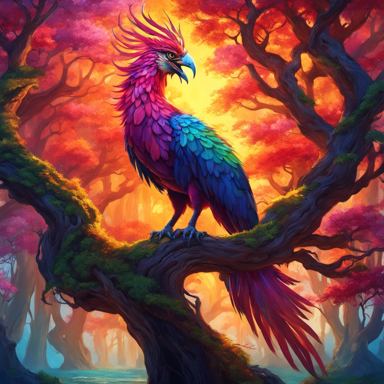

./content/generated_images/image_1728542205.jpg


In [10]:
# Display an example of a generated image

from PIL import Image
from IPython.display import display

# SOURCE_IMAGE = f"{GENERATED_IMAGES}/text_to_image_samples/phoenix_1.jpg"
SOURCE_IMAGE = f"{GENERATED_IMAGES}/image_1728542205.jpg"
source_image = Image.open(SOURCE_IMAGE).resize((384, 384))
display(source_image)
print(SOURCE_IMAGE)

## 2. Image-to-Image Example

Let's start with a simple example of image-to-image using a single image. We will use the Boto3 Python SDK with Amazon Bedrock Stability.ai Stable Diffusion XL 1.0. We will pass in a positive and negative prompt along with a source image and using those, generate a new image.


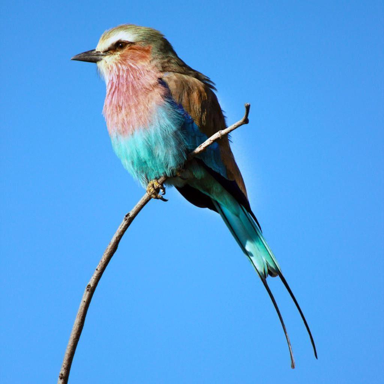

./content/source_images/image_samples/bird_cropped.jpg


In [11]:
# Image: African Lilac-breasted roller
# Image source: https://unsplash.com/photos/blue-and-brown-bird-facing-sideways-aXe4Ufe3IV4
# Source image has been cropped to 3456 × 3456 pixels and brightened

SOURCE_IMAGE = f"{SOURCE_IMAGES}/image_samples/bird_cropped.jpg"
source_image = Image.open(SOURCE_IMAGE).resize((384, 384))
display(source_image)
print(SOURCE_IMAGE)

In [12]:
# Modified version of AWS example code: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-image-image.html#model-parameters-diffusion-1-0-image-image-code-example
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
Shows how to generate an image from a reference image with SDXL 1.0 (on demand).
"""

import base64
import io
from enum import Enum, unique
import json
import logging
import boto3
from PIL import Image
import time

from botocore.exceptions import ClientError


class ImageToImageRequest:
    """
    Class for handling image to image request parameters.
    """

    def __init__(
        self,
        image_width,
        image_height,
        positive_prompt,
        negative_prompt,
        init_image_mode="IMAGE_STRENGTH",
        image_strength=0.5,
        cfg_scale=7,
        clip_guidance_preset="SLOWER",
        sampler="K_DPMPP_2M",
        samples=1,
        seed=1,
        steps=30,
        style_preset="photographic",
        extras=None,
    ):
        self.image_width = image_width
        self.image_height = image_height
        self.positive_prompt = positive_prompt
        self.negative_prompt = negative_prompt
        self.init_image_mode = init_image_mode
        self.image_strength = image_strength
        self.cfg_scale = cfg_scale
        self.clip_guidance_preset = clip_guidance_preset
        self.sampler = sampler
        self.samples = samples
        self.seed = seed
        self.steps = steps
        self.style_preset = style_preset
        self.extras = extras


@unique
class StylesPresets(Enum):
    """
    Enumerator for SDXL style presets.
    """

    THREE_D_MODEL = "3d-model"
    ANALOG_FILM = "analog-film"
    ANIME = "anime"
    CINEMATIC = "cinematic"
    COMIC_BOOK = "comic-book"
    DIGITAL_ART = "digital-art"
    ENHANCE = "enhance"
    FANTASY_ART = "fantasy-art"
    ISOMETRIC = "isometric"
    LINE_ART = "line-art"
    LOW_POLY = "low-poly"
    MODELING_COMPOUND = "modeling-compound"
    NEON_PUNK = "neon-punk"
    ORIGAMI = "origami"
    PHOTOGRAPHIC = "photographic"
    PIXEL_ART = "pixel-art"
    TILE_TEXTURE = "tile-texture"


class ImageError(Exception):
    """
    Custom exception for errors returned by SDXL 1.0.
    """

    def __init__(self, message):
        self.message = message


# Set up logging for notebook environment
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()
handler = logging.StreamHandler()
logger.addHandler(handler)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.setLevel(logging.INFO)


def generate_image_from_image(model_id, body):
    """
    Generate an image using SDXL 1.0 on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info("Generating image with SDXL model %s", model_id)

    bedrock = boto3.client(service_name="bedrock-runtime")

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())
    logger.info(f"Bedrock result: {response_body['result']}")

    base64_image = response_body.get("artifacts")[0].get("base64")
    base64_bytes = base64_image.encode("ascii")
    image_bytes = base64.b64decode(base64_bytes)

    finish_reason = response_body.get("artifacts")[0].get("finishReason")

    if finish_reason == "ERROR" or finish_reason == "CONTENT_FILTERED":
        raise ImageError(f"Image generation error. Error code is {finish_reason}")

    logger.info("Successfully generated image with the SDXL 1.0 model %s", model_id)

    return image_bytes


def image_to_image_request(
    imageToImageRequest,
    source_image,
    generated_images,
):
    """
    Entrypoint for SDXL example.
    Args:
        imageToImageRequest (ImageToImageRequest): The image to image request to use.
        generated_images (str): The directory to save the generated images to.
        source_image (str): The source image to use.
    """

    # Read source image from file and encode as base64 strings
    image = Image.open(source_image)
    new_image = image.resize(
        (imageToImageRequest.image_width, imageToImageRequest.image_height)
    )

    new_image.save(f"{source_image[:-4]}_tmp.jpg")

    with open(f"{source_image[:-4]}_tmp.jpg", "rb") as image_file:
        init_image = base64.b64encode(image_file.read()).decode("utf8")

    # Build request body
    body = json.dumps(
        {
            "text_prompts": [
                {"text": imageToImageRequest.positive_prompt, "weight": 1},
                {"text": imageToImageRequest.negative_prompt, "weight": -1},
            ],
            "init_image": init_image,
            "init_image_mode": imageToImageRequest.init_image_mode,
            "image_strength": imageToImageRequest.image_strength,
            "cfg_scale": imageToImageRequest.cfg_scale,
            "clip_guidance_preset": imageToImageRequest.clip_guidance_preset,
            "sampler": imageToImageRequest.sampler,
            "samples": imageToImageRequest.samples,
            "seed": imageToImageRequest.seed,
            "steps": imageToImageRequest.steps,
            "style_preset": imageToImageRequest.style_preset,
        }
    )

    try:
        logger.info(f"Source image: {source_image}")
        image_bytes = generate_image_from_image(model_id=MODEL_ID, body=body)
        image = Image.open(io.BytesIO(image_bytes))
        epoch_time = int(time.time())
        # generated_image_path = f"{generated_images}/image_{epoch_time}.jpg"
        generated_image_path = f"{generated_images}/image_{epoch_time}_{imageToImageRequest.seed}_{imageToImageRequest.sampler}_{imageToImageRequest.image_strength}_{imageToImageRequest.cfg_scale}_{imageToImageRequest.steps}_{imageToImageRequest.style_preset}.jpg"
        logger.info(f"Generated image: {generated_image_path}")
        # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#png
        # image.save(generated_image_path, format="PNG", compress_level=1)
        # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#jpeg-saving
        image.save(generated_image_path, format="JPEG", quality=95)

    except ClientError as err:
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
    except ImageError as err:
        logger.error(err.message)

    else:
        logger.info(f"Finished generating image with SDXL model {MODEL_ID}.")

In [13]:
# Image-to-image bird example: single variation

# Prompt inspiration: https://civitai.com/images/3030250
POSITIVE_PROMPT = "mythical beast, Phoenix, big eyes, sharp beak, long flowing feathers, bright colors, outdoors, perched on branch, no_humans, fire,scenery, cinematic lighting, strong contrast, high level of detail, best quality, masterpiece, best quality, ultra-detailed, masterpiece, hires, 8k"
NEGATIVE_PROMPT = "(worst quality:1.5), (low quality:1.5), (normal quality:1.5), low-res, bad anatomy, bad hands, watermark, moles, toes, (monochrome:1.5), (grayscale:1.5), (bad proportions:1.3)"

SOURCE_IMAGE = f"{SOURCE_IMAGES}/image_samples/bird_cropped.jpg"

# Maximum resolution for SDXL v1.0 is 1,048,576 pixels/frame (e.g., 1024 x 1024)
# Pixel width and height of the image to generate must be a multiple of 64

imageToImageRequest = ImageToImageRequest(
    image_width=1024,
    image_height=1024,
    positive_prompt=POSITIVE_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    init_image_mode="IMAGE_STRENGTH",
    image_strength=0.35,
    cfg_scale=7,
    clip_guidance_preset="NONE",
    sampler="K_DPMPP_2M",
    samples=1,
    seed=72746264,
    steps=25,
    style_preset=StylesPresets.FANTASY_ART.value,
    extras=None,
)

image_to_image_request(
    imageToImageRequest,
    SOURCE_IMAGE,
    GENERATED_IMAGES,
)

2024-10-10 13:37:38,556 - INFO - Source image: ./content/source_images/image_samples/bird_cropped.jpg
2024-10-10 13:37:38,557 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1
2024-10-10 13:38:02,101 - INFO - Bedrock result: success
2024-10-10 13:38:02,109 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:38:02,112 - INFO - Generated image: ./content/generated_images/image_1728542282_72746264_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
2024-10-10 13:38:02,164 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.


In [14]:
# Image-to-image bird example: multiple variations of the same image with random seeds

import random

# Prompt inspiration: https://civitai.com/images/3030250
POSITIVE_PROMPT = "mythical beast, Phoenix, big eyes, sharp beak, long flowing feathers, bright colors, outdoors, perched on branch, no_humans, fire,scenery, cinematic lighting, strong contrast, high level of detail, best quality, masterpiece, best quality, ultra-detailed, masterpiece, hires, 8k"
NEGATIVE_PROMPT = "(worst quality:1.5), (low quality:1.5), (normal quality:1.5), low-res, bad anatomy, bad hands, watermark, moles, toes, (monochrome:1.5), (grayscale:1.5), (bad proportions:1.3)"

SOURCE_IMAGE = f"{SOURCE_IMAGES}/image_samples/bird_cropped.jpg"

# loop through ten random seeds and generate image variations
for i in range(0, 5):
    seed = random.randrange(1, 1000000)
    print(f"Random seed: {seed}")

    imageToImageRequest = ImageToImageRequest(
        image_width=1024,
        image_height=1024,
        positive_prompt=POSITIVE_PROMPT,
        negative_prompt=NEGATIVE_PROMPT,
        init_image_mode="IMAGE_STRENGTH",
        image_strength=0.35,
        cfg_scale=7,
        clip_guidance_preset="NONE",
        sampler="K_DPMPP_2M",
        samples=1,
        seed=seed,
        steps=25,
        style_preset=StylesPresets.FANTASY_ART.value,
        extras=None,
    )

    image_to_image_request(
        imageToImageRequest,
        SOURCE_IMAGE,
        GENERATED_IMAGES,
    )

2024-10-10 13:38:02,192 - INFO - Source image: ./content/source_images/image_samples/bird_cropped.jpg
2024-10-10 13:38:02,193 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1


Random seed: 387211


2024-10-10 13:38:15,343 - INFO - Bedrock result: success
2024-10-10 13:38:15,354 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:38:15,361 - INFO - Generated image: ./content/generated_images/image_1728542295_387211_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
2024-10-10 13:38:15,436 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.
2024-10-10 13:38:15,461 - INFO - Source image: ./content/source_images/image_samples/bird_cropped.jpg
2024-10-10 13:38:15,464 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1


Random seed: 752267


2024-10-10 13:38:27,508 - INFO - Bedrock result: success
2024-10-10 13:38:27,518 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:38:27,523 - INFO - Generated image: ./content/generated_images/image_1728542307_752267_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
2024-10-10 13:38:27,582 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.
2024-10-10 13:38:27,597 - INFO - Source image: ./content/source_images/image_samples/bird_cropped.jpg
2024-10-10 13:38:27,598 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1


Random seed: 26070


2024-10-10 13:38:40,378 - INFO - Bedrock result: success
2024-10-10 13:38:40,385 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:38:40,391 - INFO - Generated image: ./content/generated_images/image_1728542320_26070_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
2024-10-10 13:38:40,445 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.
2024-10-10 13:38:40,460 - INFO - Source image: ./content/source_images/image_samples/bird_cropped.jpg
2024-10-10 13:38:40,462 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1


Random seed: 219391


2024-10-10 13:39:08,211 - INFO - Bedrock result: success
2024-10-10 13:39:08,219 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:39:08,223 - INFO - Generated image: ./content/generated_images/image_1728542348_219391_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
2024-10-10 13:39:08,275 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.
2024-10-10 13:39:08,292 - INFO - Source image: ./content/source_images/image_samples/bird_cropped.jpg
2024-10-10 13:39:08,292 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1


Random seed: 256953


2024-10-10 13:39:24,169 - INFO - Bedrock result: success
2024-10-10 13:39:24,176 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 13:39:24,181 - INFO - Generated image: ./content/generated_images/image_1728542364_256953_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
2024-10-10 13:39:24,231 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.


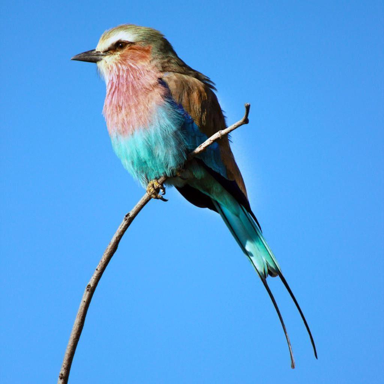

./content/source_images/image_samples/bird_cropped.jpg




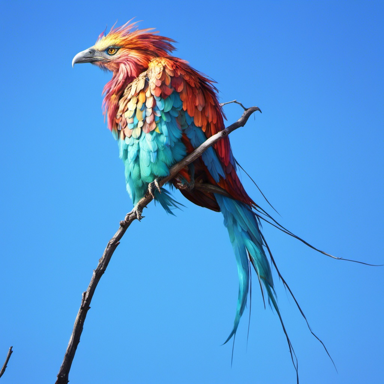


file path: ./content/generated_images/image_1728542282_72746264_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg
image_strength: 0.4
cfg_scale: 7
sampler: K_EULER
seed: 72746264
steps: 25
style_preset: fantasy-art


In [17]:
SOURCE_IMAGE = f"{SOURCE_IMAGES}/image_samples/bird_cropped.jpg"
source_image = Image.open(SOURCE_IMAGE).resize((384, 384))
display(source_image)
print(SOURCE_IMAGE)
print("\n")

# GENERATED_IMAGE = f"{GENERATED_IMAGES}/image_to_image_samples/image_to_image_00.jpg"
GENERATED_IMAGE = f"{GENERATED_IMAGES}/image_1728542282_72746264_K_DPMPP_2M_0.35_7_25_fantasy-art.jpg"
generated_image = Image.open(GENERATED_IMAGE).resize((384, 384))
display(generated_image)
print()
print(f"file path: {GENERATED_IMAGE}")
print("image_strength: 0.4")
print("cfg_scale: 7")
print("sampler: K_EULER")
print("seed: 72746264")
print("steps: 25")
print("style_preset: fantasy-art")

### Additional Image-to-Image Variations

Here a few additional image-to-image variations of the same image using different parameters.


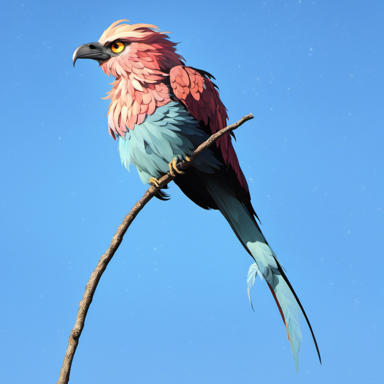

file path: ./content/generated_images/image_to_image_samples/image_to_image_02.png
image_strength: 0.5
cfg_scale: 7
seed: 72746264
steps: 25
style_preset: anime




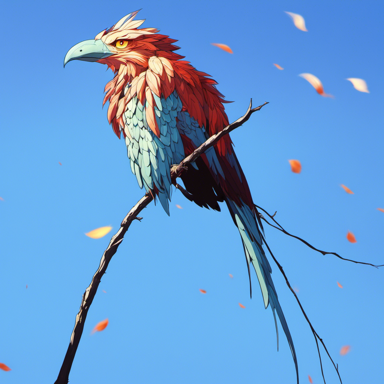

file path: ./content/generated_images/image_to_image_samples/image_to_image_03.png
image_strength: 0.3
cfg_scale: 10
seed: 72746264
steps: 50
style_preset: anime




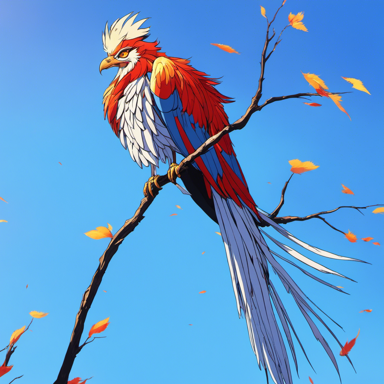

file path: ./content/generated_images/image_to_image_samples/image_to_image_04.png
image_strength: 0.2
cfg_scale: 15
seed: 72746264
steps: 50
style_preset: anime




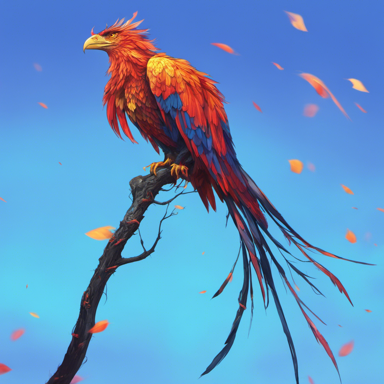

file path: ./content/generated_images/image_to_image_samples/image_to_image_05.png
image_strength: 0.1
cfg_scale: 5
seed: 72746264
steps: 25
style_preset: digital-art




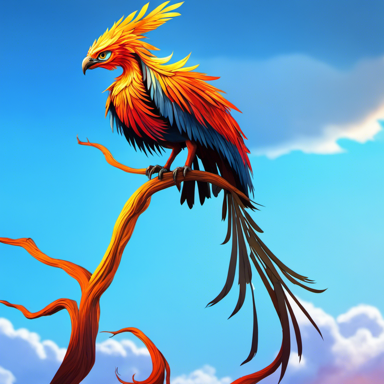

file path: ./content/generated_images/image_to_image_samples/image_to_image_06.png
image_strength: 0.1
cfg_scale: 35
seed: 2339845
steps: 50
style_preset: digital-art




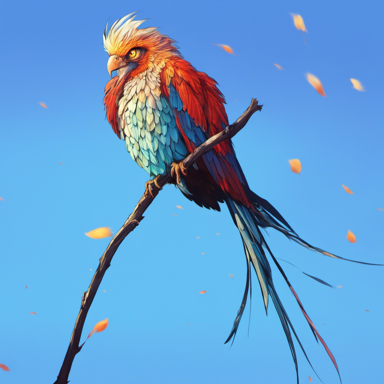

file path: ./content/generated_images/image_to_image_samples/image_to_image_07.png
image_strength: 0.5
cfg_scale: 15
seed: 46267476
steps: 25
style_preset: anime




In [21]:
i2i_variations = [
    {
        "name": "image_to_image_02",
        "image_strength": 0.5,
        "cfg_scale": 7,
        "seed": 72746264,
        "steps": 25,
        "style_preset": "anime",
    },
    {
        "name": "image_to_image_03",
        "image_strength": 0.3,
        "cfg_scale": 10,
        "seed": 72746264,
        "steps": 50,
        "style_preset": "anime",
    },
    {
        "name": "image_to_image_04",
        "image_strength": 0.2,
        "cfg_scale": 15,
        "seed": 72746264,
        "steps": 50,
        "style_preset": "anime",
    },
    {
        "name": "image_to_image_05",
        "image_strength": 0.1,
        "cfg_scale": 5,
        "seed": 72746264,
        "steps": 25,
        "style_preset": "digital-art",
    },
    {
        "name": "image_to_image_06",
        "image_strength": 0.1,
        "cfg_scale": 35,
        "seed": 2339845,
        "steps": 50,
        "style_preset": "digital-art",
    },
    {
        "name": "image_to_image_07",
        "image_strength": 0.5,
        "cfg_scale": 15,
        "seed": 46267476,
        "steps": 25,
        "style_preset": "anime",
    },
]

for i in range(2, 8):
    file_path = f"{GENERATED_IMAGES}/image_to_image_samples/image_to_image_0{i}.png"
    generated_image = Image.open(file_path).resize((384, 384))
    display(generated_image)
    print(f"file path: {file_path}")
    print(f"image_strength: {i2i_variations[i-2]['image_strength']}")
    print(f"cfg_scale: {i2i_variations[i-2]['cfg_scale']}")
    print(f"seed: {i2i_variations[i-2]['seed']}")
    print(f"steps: {i2i_variations[i-2]['steps']}")
    print(f"style_preset: {i2i_variations[i-2]['style_preset']}")
    print("\n")

## 3. Generative Video-to-Video Animation Using Amazon Bedrock

In this part of the demonstration will create a video animation using Amazon Bedrock Stability.ai Stable Diffusion XL 1.0 model. The high-level process is as follows:

1. Select a video and copy into the `source_videos` subdirectory
2. Split the video into individual frames (JPEG images) using [FFmpeg](https://kkroening.github.io/ffmpeg-python/)
3. Select a contiguous series of frames that you want to animate and copy to a new directory
4. Use the previous image-to-image method to loop through the directory of original frames and generate new frames
5. Review the resulting generated frames for anomalies and remove any unwanted frames
6. Recombine the generated frames into an video animation using [FFmpeg](https://kkroening.github.io/ffmpeg-python/)


### Sample Videos

For this part of the demonstration you will need an MP4 video. Since the maximum resolution for SDXL v1.0 is 1,048,576 pixels (e.g., 1024 x 1024), I recommend a video whose dimensions are 1280 x 720, which is 921,600 pixels. You can find many such copyright free videos on the Internet, including from sources such as [Pixabay](https://pixabay.com). I will be using the following video of [Red Squirrel squirrel eating](https://pixabay.com/videos/red-squirrel-squirrel-eating-food-161933/). Make sure to select the 1280×720 MP4 4.8 MB version when downloading.

Copy all your source videos into the `./content/source_videos/` subdirectory within the project.


In [22]:
# Video 1: Red Squirrel
# Display the source video
# Source: https://pixabay.com/videos/red-squirrel-squirrel-eating-food-161933/

from IPython.display import Video

Video(
    url=f"{SOURCE_VIDEOS}/161933-824623538_small.mp4",
    width=(1280 / 2),
    height=(720 / 2),
    html_attributes="controls muted autoplay loop",
)

### Split the Video Frames

Split the video into individual frames (JPEG images) using [FFmpeg](https://kkroening.github.io/ffmpeg-python/).


In [23]:
# Video 1: Red Squirrel
# Source: https://pixabay.com/videos/red-squirrel-squirrel-eating-food-161933/
# FFmpeg arguments reference: `ffmpeg -h long`

import ffmpeg

SOURCE_VIDEO = f"{SOURCE_VIDEOS}/161933-824623538_small.mp4"
SOURCE_VIDEO_FRAMES = f"{SOURCE_FRAMES}/demo1"

(
    ffmpeg.input(
        SOURCE_VIDEO,
    )
    .output(
        f"{SOURCE_VIDEO_FRAMES}/frame%d.jpg",
        start_number=1,
        qscale=1,
    )
    .overwrite_output()
    .run(quiet=False)
)

(None, None)

### Generate Frames from Source Frames

Use the previous image-to-image technique to generate a new frame for each original frame using identical prompts and other model parameters.


In [44]:
# Video 1: Red Squirrel

POSITIVE_PROMPT = "red squirrel, in the style of Ghibli studio style"
NEGATIVE_PROMPT = "out of frame, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

SOURCE_VIDEO_FRAMES = f"{SOURCE_FRAMES}/demo1"
GENERATED_VIDEO_FRAMES = f"{GENERATED_FRAMES}/demo1"

# Maximum resolution for SDXL v1.0 is 1,048,576 pixels/frame (e.g., 1024 x 1024)
# Pixel width and height of the image to generate must be a multiple of 64
# Current video frames: 1280 W x 720 H = 921,600 pixels
# 1280/64 = 20
# 720/64 = 11.25 > 11

imageToImageRequest = ImageToImageRequest(
    image_width=(20 * 64),
    image_height=(11 * 64),
    positive_prompt=POSITIVE_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    init_image_mode="IMAGE_STRENGTH",
    image_strength=0.4,
    cfg_scale=15,
    clip_guidance_preset="SLOWEST",
    sampler="K_DPMPP_2M",  # DPM++ 2M Karras (https://stable-diffusion-art.com/samplers/)
    samples=1,
    seed=123234343,
    steps=25,
    style_preset=StylesPresets.ANIME.value,
    extras=None,
)

# Loop through all the frames in the source video or a selection of frames
for i in range(200, 380, 2):
    image_to_image_request(
        imageToImageRequest,
        f"{SOURCE_VIDEO_FRAMES}/frame{i}.jpg",
        GENERATED_VIDEO_FRAMES,
    )

2024-10-10 18:18:17,430 - INFO - Source image: ./content/source_frames/demo1/frame200.jpg
2024-10-10 18:18:17,431 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1
2024-10-10 18:18:28,315 - INFO - Bedrock result: success
2024-10-10 18:18:28,324 - INFO - Successfully generated image with the SDXL 1.0 model stability.stable-diffusion-xl-v1
2024-10-10 18:18:28,328 - INFO - Generated image: D:\AWSStudy\GenAI_Video_Animations\windows\content\generated_frames/demo1/image_1728559108_123234343_K_DPMPP_2M_0.4_15_25_anime.jpg
2024-10-10 18:18:28,378 - INFO - Finished generating image with SDXL model stability.stable-diffusion-xl-v1.
2024-10-10 18:18:28,431 - INFO - Source image: ./content/source_frames/demo1/frame202.jpg
2024-10-10 18:18:28,433 - INFO - Generating image with SDXL model stability.stable-diffusion-xl-v1
2024-10-10 18:18:37,644 - INFO - Bedrock result: success
2024-10-10 18:18:37,651 - INFO - Successfully generated image with the SDXL 1.0 model stability.st

### Recombine Generated Frames into Video Animation

Recombine the generated frames into an video animation using [FFmpeg](https://kkroening.github.io/ffmpeg-python/).


In [45]:
import os

GENERATED_VIDEO_FRAMES = os.path.join(GENERATED_FRAMES, 'demo1')

# Get a sorted list of your image files
image_files = sorted([f for f in os.listdir(GENERATED_VIDEO_FRAMES) if f.endswith('.jpg')])

# Rename the files to sequential numbering
for idx, filename in enumerate(image_files):
    new_name = f"frame{idx:06d}.jpg"  # Adjust the number of zeros as needed
    src = os.path.join(GENERATED_VIDEO_FRAMES, filename)
    dst = os.path.join(GENERATED_VIDEO_FRAMES, new_name)
    os.rename(src, dst)

In [46]:
# Video 1: Red Squirrel
# Recombine generated frames into a video

import ffmpeg

GENERATED_VIDEO_FRAMES = f"{GENERATED_FRAMES}/demo1"
GENERATED_VIDEO = f"{GENERATED_VIDEOS}/demo1.mp4"

# Sử dụng ffmpeg để kết hợp các file ảnh đã đổi tên
(
    ffmpeg.input(
        f"{GENERATED_VIDEO_FRAMES}/frame%06d.jpg",  # Sử dụng định dạng file đã được đổi tên
        framerate=9,
    )
    .output(GENERATED_VIDEO)
    .run(overwrite_output=True)
)

(None, None)

In [ ]:
# Video 1: Red Squirrel
# Display the generated video
# 40 frames, 9 fps, forward only

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo1.mp4",
    width=1280 / 2,
    height=720 / 2,
    html_attributes="controls muted autoplay loop",
)

### Optional: Use FFmpeg from the Terminal

Commands will create a 1/ normal video, 2/ reversed video, and 3/ combined video, as shown in the diagram below.


![frame_composition](./assets/video-frames.png)


In [39]:
import os

# Lấy đường dẫn tuyệt đối tới thư mục 'content'
content_dir = os.path.abspath("./content")

# Lấy đường dẫn thư mục cha của 'content'
parent_dir = os.path.dirname(content_dir)

# Thiết lập các biến dựa trên đường dẫn mới
GENERATED_FRAMES = os.path.join(content_dir, "generated_frames")
GENERATED_VIDEOS = os.path.join(content_dir, "generated_videos")
VIDEO_NAME = "demo1"

In [40]:
# Tạo video từ các file ảnh
!ffmpeg -framerate 30 -i "{GENERATED_FRAMES}/{VIDEO_NAME}/frame%04d.jpg" -y "{GENERATED_VIDEOS}/{VIDEO_NAME}.mp4"

ffmpeg version N-117438-gec9985b54f-20241009 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.0 (crosstool-NG 1.26.0.106_ed12fa6)
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-libxml2 --enable-lzma --enable-fontconfig --enable-libharfbuzz --enable-libvorbis --enable-opencl --disable-libpulse --enable-libvmaf --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-libaribb24 --enable-avisynth --enable-chromaprint --enable-libdav1d --enable-libdavs2 --enable-libdvdread --enable-libdvdnav --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --enable-frei0r --enable-libgme --enable-libkvazaar --enable-libaribcaption --enable-libass --enable-libbluray --enable-li

In [41]:
# Tạo video đảo ngược
!ffmpeg -i "{GENERATED_VIDEOS}/{VIDEO_NAME}.mp4" -vf reverse -y "{GENERATED_VIDEOS}/{VIDEO_NAME}_reversed.mp4"

ffmpeg version N-117438-gec9985b54f-20241009 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.0 (crosstool-NG 1.26.0.106_ed12fa6)
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-libxml2 --enable-lzma --enable-fontconfig --enable-libharfbuzz --enable-libvorbis --enable-opencl --disable-libpulse --enable-libvmaf --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-libaribb24 --enable-avisynth --enable-chromaprint --enable-libdav1d --enable-libdavs2 --enable-libdvdread --enable-libdvdnav --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --enable-frei0r --enable-libgme --enable-libkvazaar --enable-libaribcaption --enable-libass --enable-libbluray --enable-li

In [42]:
# Tạo file vidlist.txt chứa danh sách các video
vidlist_content = f"file '{GENERATED_VIDEOS}/{VIDEO_NAME}.mp4'\nfile '{GENERATED_VIDEOS}/{VIDEO_NAME}_reversed.mp4'"
with open("vidlist.txt", "w") as f:
    f.write(vidlist_content)

In [43]:
# Kết hợp hai video thành một
!ffmpeg -f concat -safe 0 -i vidlist.txt -c copy -y "{GENERATED_VIDEOS}/{VIDEO_NAME}_combined.mp4"

ffmpeg version N-117438-gec9985b54f-20241009 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.0 (crosstool-NG 1.26.0.106_ed12fa6)
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-libxml2 --enable-lzma --enable-fontconfig --enable-libharfbuzz --enable-libvorbis --enable-opencl --disable-libpulse --enable-libvmaf --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-libaribb24 --enable-avisynth --enable-chromaprint --enable-libdav1d --enable-libdavs2 --enable-libdvdread --enable-libdvdnav --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --enable-frei0r --enable-libgme --enable-libkvazaar --enable-libaribcaption --enable-libass --enable-libbluray --enable-li

In [ ]:
# Video 1: Red Squirrel
# Display the combined video
# 40 frames, 9 fps, both forward and reverse

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo1_combined.mp4",
    width=(1280 / 2),
    height=(720 / 2),
    html_attributes="controls muted autoplay loop",
)

In [ ]:
# Video 2: Man Dancing
# Source: https://mixkit.co/free-stock-video/cheerful-man-in-a-suit-dancing-energetically-on-a-white-45471/

POSITIVE_PROMPT = "anime-style male dancer, caucasian, brightly colored hair, dressed in bright vibrant colors clothing, 1man, white background, empty hands"
NEGATIVE_PROMPT = "photographic, photorealistic, photograph, (holding objects), (objects in hands), hat, (spot light), out of frame, lowres, text, error, cropped, (background objects), scenery, spot light, worst quality, low quality, jpeg artifacts, bad eyes, bad teeth, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

SOURCE_VIDEO_FRAMES = f"{SOURCE_FRAMES}/demo2"
GENERATED_VIDEO_FRAMES = f"{GENERATED_FRAMES}/demo2"

imageToImageRequest = ImageToImageRequest(
    image_width=(20 * 64),
    image_height=(11 * 64),
    positive_prompt=POSITIVE_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    init_image_mode="IMAGE_STRENGTH",
    image_strength=0.3,
    cfg_scale=15,
    clip_guidance_preset="SLOWEST",
    sampler="K_DPMPP_2M",
    samples=1,
    seed=74828924,
    steps=25,
    style_preset=StylesPresets.ANIME.value,
    extras=None,
)

# Loop through all the frames in the source video or a selection of frames
for i in range(0, 100, 1):
    image_to_image_request(
        imageToImageRequest,
        f"{SOURCE_VIDEO_FRAMES}/frame{i}.jpg",
        GENERATED_VIDEO_FRAMES,
    )

In [ ]:
# Video 2: Man Dancing
# Display the generated video
# 92 frames, 9 fps, forward and reverse
# Some retouching in Adobe Photoshop to remove strong background spot light effects
# Deleted any frames where the dancer was holding an object

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo2_combined.mp4",
    width=(1280 / 2),
    height=(704 / 2),
    html_attributes="controls muted autoplay loop",
)

In [ ]:
# Video 3: Happy Guy
# Source: https://www.pexels.com/video/a-happy-man-looking-at-camera-8628513/

# Prompt inspiration: https://prompthero.com/prompt/15632093a39
POSITIVE_PROMPT = "young man with light brown wavy hair, eye glasses, looking directly at the camera, empty hands, pixar style, disney pixar, office background, ultra detailed, 1man"
NEGATIVE_PROMPT = "out of frame, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, bad eyes, bad teeth, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

SOURCE_VIDEO_FRAMES = f"{SOURCE_FRAMES}/demo3"
GENERATED_VIDEO_FRAMES = f"{GENERATED_FRAMES}/demo3"

imageToImageRequest = ImageToImageRequest(
    image_width=(11 * 64),
    image_height=(20 * 64),
    positive_prompt=POSITIVE_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    init_image_mode="IMAGE_STRENGTH",
    image_strength=0.5,
    cfg_scale=10,
    clip_guidance_preset="SLOWEST",
    sampler="K_DPMPP_2M",
    samples=1,
    seed=74828924,
    steps=25,
    style_preset=StylesPresets.DIGITAL_ART.value,
    extras=None,
)

# Loop through all the frames in the source video or a selection of frames
for i in range(65, 114, 1):
    image_to_image_request(
        imageToImageRequest,
        f"{SOURCE_VIDEO_FRAMES}/frame{i}.jpg",
        GENERATED_VIDEO_FRAMES,
    )

In [ ]:
# Video 3: Happy Guy
# Display the generated video
# 47 frames, 9 fps, both forward and reverse

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo3_combined.mp4",
    width=(704 / 2),
    height=(1280 / 2),
    html_attributes="controls muted autoplay loop",
)

In [ ]:
# Video 4: Selfie 1
# Prompt inspiration: https://medium.com/phygital/top-40-useful-prompts-for-stable-diffusion-xl-008c03dd0557

# v1: 0.3 7 30 digital-art
# POSITIVE_PROMPT = "dignified older man with weather-worn features, deep wrinkles, thick graying mustache, Sam Elliot mustache, bright blue eyes, (solid black shirt:2.0), plain black t-shirt, digitally enhanced, high contrast, intimate, close-up, detailed, steady gaze, rendered in sepia tones, timeless, expressive, highly detailed, sharp focus, high resolution"
# NEGATIVE_PROMPT = "beard, hair on chin, out of frame, print shirt, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, bad eyes, bad teeth, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, long neck, username, ((watermark)), ((signature)), ((text)), ((logo)), ((branding)), ((copyright)), ((trademark))"

# v2: 0.7 10 25 fantasy-art 89435389
POSITIVE_PROMPT = "dignified young man with wavy dark brown hair, bright blue eyes, solid black t-shirt, digitally enhanced, high contrast, intimate, close-up, detailed, steady gaze, rendered in sepia tones, timeless, expressive, highly detailed, sharp focus, high resolution"
NEGATIVE_PROMPT = "beard, hair on chin, out of frame, print shirt, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, bad eyes, bad teeth, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, long neck, username, ((watermark)), ((signature)), ((text)), ((logo)), ((branding)), ((copyright)), ((trademark))"

SOURCE_VIDEO_FRAMES = f"{SOURCE_FRAMES}/demo4"
GENERATED_VIDEO_FRAMES = f"{GENERATED_FRAMES}/demo54"

imageToImageRequest = ImageToImageRequest(
    image_width=(9 * 64),
    image_height=(16 * 64),
    positive_prompt=POSITIVE_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    init_image_mode="IMAGE_STRENGTH",
    image_strength=0.7,
    cfg_scale=10,
    clip_guidance_preset="SLOWEST",
    sampler="K_DPMPP_2M",
    samples=1,
    seed=89435389,
    steps=25,
    style_preset=StylesPresets.FANTASY_ART.value,
    extras=None,
)

# Loop through all the frames in the source video or a selection of frames
for i in range(76, 150, 1):
    image_to_image_request(
        imageToImageRequest,
        f"{SOURCE_VIDEO_FRAMES}/frame{i}.jpg",
        GENERATED_VIDEO_FRAMES,
    )

In [ ]:
# Video 4: Selfie 1 v1
# Display the generated video
# 26 frames, 9 fps, both forward and reverse
# Some retouching in Adobe Photoshop to remove fake artists signatures
# Deleted any frames where the shirt had a pattern or face changed to much

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo4a_combined.mp4",
    width=(576 / 2),
    height=(1024 / 2),
    html_attributes="controls muted autoplay loop",
)

In [ ]:
# Video 4: Selfie 1 v2
# Display the generated video
# 24 frames, 9 fps, both forward and reverse
# Deleted any frames where the shirt had a pattern or face changed to much

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo4b_combined.mp4",
    width=(576 / 2),
    height=(1024 / 2),
    html_attributes="controls muted autoplay loop",
)

In [ ]:
# Video 5: Selfie 2

# Prompt inspiration: https://medium.com/phygital/top-40-useful-prompts-for-stable-diffusion-xl-008c03dd0557
POSITIVE_PROMPT = "dignified older man with weather-worn features, deep wrinkles, thick graying mustache, Sam Elliot mustache, bright blue eyes, (solid black shirt:2.0), plain black t-shirt, Newsboy Hat, Cabbie Hat, Gatsby Hat, digitally enhanced, high contrast, intimate, close-up, detailed, steady gaze, rendered in sepia tones, timeless, expressive, highly detailed, sharp focus, high resolution"
NEGATIVE_PROMPT = "eyeglasses, glasses, beard, hair on chin, out of frame, print shirt, lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, bad eyes, bad teeth, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, long neck, username, ((watermark)), ((signature)), ((text)), ((logo)), ((branding)), ((copyright)), ((trademark))"

SOURCE_VIDEO_FRAMES = f"{SOURCE_FRAMES}/demo5"
GENERATED_VIDEO_FRAMES = f"{GENERATED_FRAMES}/demo5"

# 7a 0.5 10 30 digital-art
# 7b 0.2 10 25 modeling-compound 939393
# 7a 0.9 5 50 modeling-compound 939393

imageToImageRequest = ImageToImageRequest(
    image_width=(9 * 64),
    image_height=(16 * 64),
    positive_prompt=POSITIVE_PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    init_image_mode="IMAGE_STRENGTH",
    image_strength=0.2,
    cfg_scale=10,
    clip_guidance_preset="SLOWEST",
    sampler="K_DPMPP_2M",
    samples=1,
    seed=748278427,
    steps=25,
    style_preset=StylesPresets.MODELING_COMPOUND.value,
    extras=None,
)

# Loop through all the frames in the source video or a selection of frames
for i in range(200, 230, 1):
    image_to_image_request(
        imageToImageRequest,
        f"{SOURCE_VIDEO_FRAMES}/frame{i}.jpg",
        GENERATED_VIDEO_FRAMES,
    )

In [ ]:
# Video 5: Selfie 2
# Display the generated video
# 29 frames, 6 fps, both forward and reverse
# Deleted any frames where the eyes were bad or overall image style was dissimilar

from IPython.display import Video

Video(
    url=f"{GENERATED_VIDEOS}/demo5_combined.mp4",
    width=(576 / 2),
    height=(1024 / 2),
    html_attributes="controls muted autoplay loop",
)

## State-of-the-Art Generative AI Animation

This demonstration was very basic. If you are interested in state-of-the-art Generative AI image and video generation techniques, I would suggest looking at a combination of the AnimateDiff, ControlNet, IP-Adapter, and A1111 or ComfyUI, along with the use of custom fine-tuned SDXL models. Most high-quality animations are created with multiple fine-tuned SDXL LoRAs (Low-Rank Adaptation of Large Language Models). These tools can all be used on AWS using a GPU-based [Amazon WorkSpaces](https://aws.amazon.com/pm/workspaces/) environment.

- [Automatic1111 (aka A1111) Stable Diffusion web UI](https://github.com/AUTOMATIC1111/stable-diffusion-webui)
- [ComfyUI Stable Diffusion web UI](https://github.com/comfyanonymous/ComfyUI)
- [AnimateDiff](https://animatediff.github.io/)
- [ControlNet](https://github.com/lllyasviel/ControlNet)
- [IP-Adapter](https://github.com/tencent-ailab/IP-Adapter/)
- [AnimateDiff for Stable Diffusion WebU (A1111)](https://github.com/continue-revolution/sd-webui-animatediff)
- [ControlNet for Stable Diffusion WebUI (A1111)](https://github.com/Mikubill/sd-webui-controlnet)
- [Fine-tuned Stable Diffusion XL LoRAs](https://civitai.com/models)
- [Hugging Face: LoRA the Explorer](https://huggingface.co/spaces/multimodalart/LoraTheExplorer)

If you are looking for examples of state-of-the-art Generative AI-based animations, check out [Civitai](https://civitai.com/videos). **WARNING! EXTREMELY INAPPROPRIATE CONTENT!**
